In [4]:

!pip install helical --use-pep517

!pip install datasets --upgrade

  Using cached helical-0.0.1a16-py3-none-any.whl.metadata (51 kB)
  Using cached accelerate-0.29.3-py3-none-any.whl.metadata (18 kB)
  Using cached anndata-0.10.7-py3-none-any.whl.metadata (6.6 kB)
  Using cached azure_core-1.30.1-py3-none-any.whl.metadata (37 kB)
  Using cached azure_identity-1.16.0-py3-none-any.whl.metadata (76 kB)
  Using cached azure_storage_blob-12.19.1-py3-none-any.whl.metadata (26 kB)
  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached loompy-3.0.7-py3-none-any.whl
  Using cached louvain-0.8.2.tar.gz (4.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend d

  error: subprocess-exited-with-error
  
  × Building wheel for louvain (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      C:\Users\tomjo\AppData\Local\Temp\pip-build-env-pqwnljq2\overlay\Lib\site-packages\setuptools\_distutils\dist.py:261: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      WARNING setuptools_scm.pyproject_reading toml section missing 'pyproject.toml does not contain a tool.setuptools_scm section'
      Traceback (most recent call last):
        File "C:\Users\tomjo\AppData\Local\Temp\pip-build-env-pqwnljq2\normal\Lib\site-packages\setuptools_scm\_integration\pyproject_reading.py", line 36, in read_pyproject
          section = defn.get("tool", {})[tool_name]
                    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
      KeyError: 'setuptools_scm'
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\louvain
      copying src\louvain\f

In [2]:

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import torch
print(torch.__version__)  # Should print a version like 2.0.1+cu118 or 2.1.0+cu121
print(torch.version.cuda)  # Should print the CUDA version (e.g., 11.8 or 12.1)
print(torch.cuda.is_available()) 

INFO:datasets:PyTorch version 2.5.1+cu118 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


2.5.1+cu118
11.8
True


In [3]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[:65%]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1717.12 examples/s]


In [4]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

In [5]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): dataset that is being considered
      model ()
  """
  # knockout genes using batching to reduce explosion in RAM usage
  batch_size = 100
  original_data = data.copy()
  #print(len(genes))
  
  gene_indices = [data.var.index.get_loc(gene) for gene in genes if gene in data.var.index]
  # update data in a vectorised way all at once to reduce memory spike
  data.X[:,gene_indices] = 0 
  
  new_data = model.process_data(adata = data, gene_names="gene_name")
  print([i for i in range(100) if data.var["gene_name"][i] not in new_data.vocab])
  
  
  x_model_dropped = model.get_embeddings(new_data)
  # generate embeddings on original data
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  x_model = model.get_embeddings(new_data1)
  return x_model, x_model_dropped
#genes_to_knockout = ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M']
genes_to_knockout = list(adata.var_names[0:40])

x_modelt, x_model_droppedt = knockout_genes(adata,scgpt,genes_to_knockout)


INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[15, 23, 33, 34, 39, 82]


Embedding cells: 100%|██████████| 330/330 [03:22<00:00,  1.63it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [03:29<00:00,  1.58it/s]


In [190]:
#axis=0 gives largest embedding, axis=1 gives example with largest impact

print(np.argmax(np.sum(x_model,0)))
print(np.argmax(np.sum(x_model,1)))
print(np.argmax(np.sum(x_model_dropped,0)))
print(np.argmax(np.sum(x_model_dropped,1)))
print(np.argmin(np.sum(x_model,0)))
print(np.argmin(np.sum(x_model,1)))
print(np.argmin(np.sum(x_model_dropped,0)))
print(np.argmin(np.sum(x_model_dropped,1)))

260
9950
260
9950
157
12522
157
9839


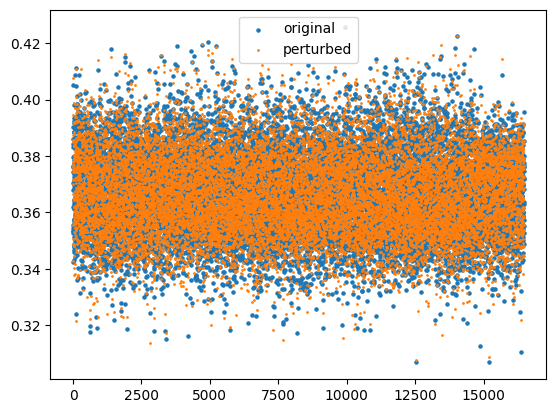

16473


In [198]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_modelt,axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_model_droppedt,axis=1), label="perturbed",s=1)
plt.legend()
plt.show()
error = 0
index = 0
x = np.sum(x_modelt,axis=1)
y = np.sum(x_model_droppedt,axis=1)
for i in range(len(x_modelt[:,0])):
    squared_error = (x[i]-y[i])**2
    if squared_error > error:
        index=i

print(i)

In [209]:
data = adata.obs.iloc[16473]
print(data['rows'])
print([knockout[i] in data['rows'] for i in range(len(knockout))])

[   10    18    19 ... 37299 37306 37309]
[True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In this cell example almost all of the genes that have been knocked out are present, so the fact that this example has changed by the largest amount in importance is to be expected.

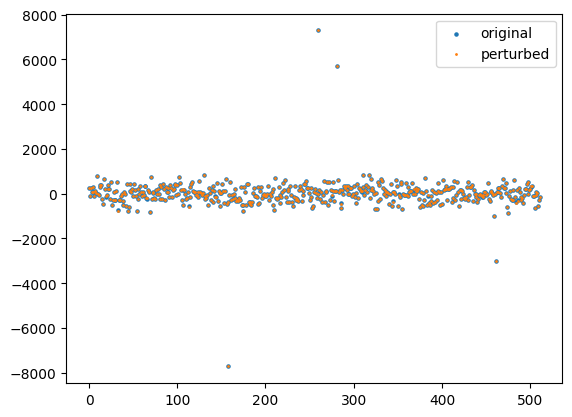

In [195]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_modelt,axis=0), label="original",s=5)
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_model_droppedt,axis=0), label="perturbed",s=1)
plt.legend()
plt.show()


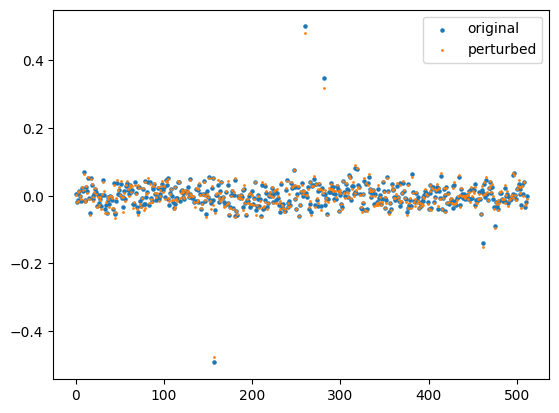

[False False False False False False False False False False]


In [10]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[16,:]))), x_modelt[16,:], label="original",s=5)
plt.scatter( list(range(len(x_modelt[16,:]))), x_model_droppedt[16,:], label="perturbed",s=1)
plt.legend()
plt.show()
print(x_modelt[0:10,i]==x_model_droppedt[0:10,i])

In [11]:

# for all embeddings find the MSE between orginal and unperturbed data
#for i in range(len(x_model[0])):
mse = 0
for i,j in zip(x_modelt,x_model_droppedt):
  mse += (i-j)**2
# find which embedding depends the most on the genes that have been knocked out
print(np.argmax(mse))
mse = 0
for i,j in zip(x_modelt.T,x_model_droppedt.T):
  mse += (i-j)**2
# find which genes now has been reduced in importance by the largest amount
print(np.argmax(mse))


281
237


In [50]:
#genes_to_knockout = list(adata.var_names[0:int(len(adata.var_names)/10)])
x_model10, x_model_dropped10 = 0,0
#genes_to_knockout = list(adata.var_names[0:int(len(adata.var_names)/5)])
x_model20, x_model_dropped20 = 0,0
#genes_to_knockout = list(adata.var_names[0:int(len(adata.var_names)/2)])
x_model50, x_model_dropped50 = 0,0


In [ ]:
mse = 0
for i,j in zip(x_model,x_model_dropped):
  mse += (i-j)**2
# find which embedding depends the most on the genes that have been knocked out
print(np.argmax(mse))
mse = 0
for i,j in zip(x_model.T,x_model_dropped.T):
  mse += (i-j)**2
# find which genes now has been reduced in importance by the largest amount
print(np.argmax(mse))
print(np.shape(x_model))

In [13]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
print(num_types)


6


Neural network:

In [173]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()

In [ ]:
# embedding dimension is 512 (no nn.Dropout)
input_shape = 512
def build_model(hidden_layer_sizes,activation_function):
    classification_model = nn.Sequential(
    nn.Linear(input_shape, hidden_layer_sizes[0]),
    activation_function,
    nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
    activation_function,
    nn.Linear(hidden_layer_sizes[1], num_classes)
    )
    return classification_model

classification_model = build_model([128,32],nn.ReLU())



In [158]:
def train_model(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            if plotting:
                train_losses = []
                for train_X, train_y in train_loader:
                    train_outputs = model(train_X)
                    train_loss = loss_fn(train_outputs, train_y)
                    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
            global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "train loss")  
        plt.legend()
        plt.show()

    model.eval()   
    return model

In [145]:
def train_mode_MSE(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            
            #train_losses = []
            #for train_X, train_y in train_loader:
            #    train_outputs = model(train_X)
            #    train_loss = loss_fn(train_outputs, train_y)
            #    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
           # global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "train loss")  
        plt.legend()
        plt.show()

    model.eval()   
    return model, global_train_losses, global_val_losses

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.10745740650182074
Epoch 2, Validation Loss: 0.08625875314340946
Epoch 3, Validation Loss: 0.07412594943208263
Epoch 4, Validation Loss: 0.06512693933984066
Epoch 5, Validation Loss: 0.06133079431713261
Epoch 6, Validation Loss: 0.06137421727180481
Epoch 7, Validation Loss: 0.05530054947519873
Epoch 8, Validation Loss: 0.05446869763050308
Epoch 9, Validation Loss: 0.052901107827795946
Epoch 10, Validation Loss: 0.05201353560736839
Epoch 11, Validation Loss: 0.050149538425451265
Epoch 12, Validation Loss: 0.05005535336974216
Epoch 13, Validation Loss: 0.0529822050098409
Epoch 14, Validation Loss: 0.05000899309054651
Epoch 15, Validation Loss: 0.04527399256488586
Epoch 16, Validation Loss: 0.049439967055111486
Epoch 17, Validation Loss: 0.05429395

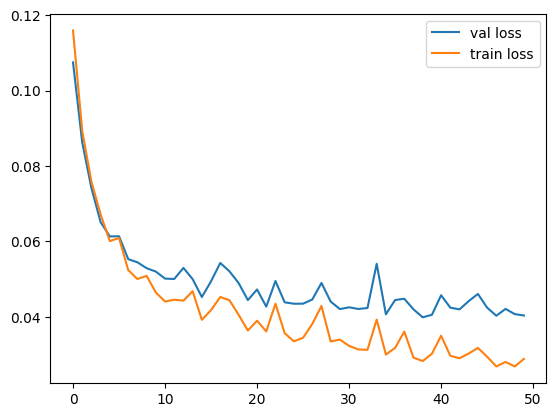

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)


classification_model = build_model([128,32],nn.ReLU())
new_model = deepcopy(classification_model)
print(new_model)
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

This large difference between the validation and training loss implies the model is overfitting 

In [165]:
from sklearn.model_selection import ParameterGrid, GridSearchCV, KFold
def perform_hyperparameter_search(X_train, y_train):
    # Ensure to add whatever inputs you deem necessary to this function
    """
    Performs a hyper-parameter for fine-tuning the regressor implemented
    in the Regressor class.

    Arguments:
        Add whatever inputs you need.

    Returns:
        The function should return your optimised hyper-parameters.

    """

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    parameter_grid = {
      
        'learning_rate': [0.01,0.001],
        'hidden_layer_size': [[256, 64],[128, 32],[128, 64]],
        'activation_fn': [torch.nn.ReLU(),torch.nn.Tanh()],
        'nb_epoch': [50]
    }
    best_loss = float('inf')
    best_params = None
    grid = ParameterGrid(parameter_grid)

    # Create 80/20 train/val split
    split_point_X = int(0.8*len(X_train))
    split_point_y = int(0.8*len(y_train))
    X_val = X_train[split_point_X:]
    X_train = X_train[:split_point_X]
    y_val = y_train[split_point_y:]
    y_train = y_train[:split_point_y]

    for parameters in grid:
        print(f"Testing parameters: {parameters}")
       
        if True:
            
            classification_model = build_model(parameters['hidden_layer_size'],parameters['activation_fn'])
            print(classification_model)
          
            classification_model, list_of_MSE_per_epoch, list_of_val = train_mode_MSE(classification_model, 
                torch.from_numpy(X_train), 
                y_train, 
                torch.from_numpy(X_test), 
                y_test,
                optim.Adam(classification_model.parameters(), lr=parameters['learning_rate'],weight_decay=1e-4),
                nn.CrossEntropyLoss(),
                num_epochs = parameters['nb_epoch'],
                plotting = False)

            min_loss = np.min(list_of_val)
            print(min_loss)
        # Update the best model if this one performs better
        if min_loss < best_loss:
            best_loss = min_loss
            best_params = parameters
            

    print("Best Parameters:", best_params)
    print("Lowest loss:", best_loss)
    return best_params


In [166]:
print(perform_hyperparameter_search(X_train, y_train))

Testing parameters: {'activation_fn': ReLU(), 'hidden_layer_size': [256, 64], 'learning_rate': 0.01, 'nb_epoch': 50}
Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.05951607159267251
Epoch 2, Validation Loss: 0.05253257700958504
Epoch 3, Validation Loss: 0.052997573296754405
Epoch 4, Validation Loss: 0.05350449376811202
Epoch 5, Validation Loss: 0.05324147906727516
Epoch 6, Validation Loss: 0.051979492230412476
Epoch 7, Validation Loss: 0.05730461404443933
Epoch 8, Validation Loss: 0.050515173880669936
Epoch 9, Validation Loss: 0.0622891945979343
Epoch 10, Validation Loss: 0.056483669815441735
Epoch 11, Validation Loss: 0.05435344896530016
Epoch 12, Validation Loss: 0.04064594644408386
Epoch 13, Validation Loss: 0.0544328866705585
Epoch 14, Validation Loss: 0.05589687672013847
Epoch 15, Vali

Update model parameters to the optimal ones found by the hyperparameter search:

Epoch 1, Validation Loss: 0.07540105007445583
Epoch 2, Validation Loss: 0.055063333039960034
Epoch 3, Validation Loss: 0.049163095509776704
Epoch 4, Validation Loss: 0.04453455959446728
Epoch 5, Validation Loss: 0.05228027070944126
Epoch 6, Validation Loss: 0.05024662094477277
Epoch 7, Validation Loss: 0.041585534291628465
Epoch 8, Validation Loss: 0.04474147271293287
Epoch 9, Validation Loss: 0.04237968229258863
Epoch 10, Validation Loss: 0.04373132720446357
Epoch 11, Validation Loss: 0.039201204145613774
Epoch 12, Validation Loss: 0.044795886147767305
Epoch 13, Validation Loss: 0.03959098035612932
Epoch 14, Validation Loss: 0.0405817264243244
Epoch 15, Validation Loss: 0.044854088372980744
Epoch 16, Validation Loss: 0.040268776015951656
Epoch 17, Validation Loss: 0.0354813926298028
Epoch 18, Validation Loss: 0.044705419783265546
Epoch 19, Validation Loss: 0.03431914010658287
Epoch 20, Validation Loss: 0.04042016308700953
Epoch 21, Validation Loss: 0.03394674190069334
Epoch 22, Valida

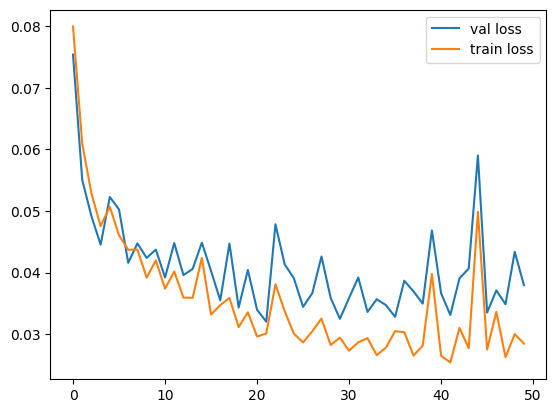

In [258]:

X_train, X_val, y_train, y_val = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)
classification_model = build_model([128,64],nn.Tanh())
new_model = deepcopy(classification_model)
# dont need val set as this is our final model, so train on whole train set
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

In [259]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  precision_l = precision_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  f1_l = f1_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  recall_l = recall_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  print(f"Lymphoid precision: {(precision_l*100):.1f}%")
  print(f"Lymphoid f1: {(f1_l*100):.1f}%")
  print(f"Lymphoid recall: {(recall_l*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [262]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1654.79 examples/s]


In [263]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata_unseen = ad.AnnData(lil.tocsr(),obs=obs_data)
adata_unseen.var_names = ds.features['raw_counts'].id.split(",")
adata_unseen.var['gene_name'] = adata_unseen.var_names.str.upper()

In [264]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = new_model(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 153/153 [01:15<00:00,  2.02it/s]


In [265]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

print(precision_score(y_true_unseen, y_pred_unseen, average=None,labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK']))
results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

[0.99735537 0.99852768 0.97687327 0.59375    0.6        0.89795918]
Evaluation set accuracy: 99.2%
Evaluation set precision: 84.4%
Evaluation set f1: 85.6%
Evaluation set recall: 88.0%
Lymphoid precision: 59.4%
Lymphoid f1: 70.4%
Lymphoid recall: 86.4%


In [245]:
print(sum([y_pred_unseen[i]=='LYMPHOID' for i in range(len(y_pred_unseen))]))
print(y_pred_unseen)
print(sum([y_true_unseen[i]=='LYMPHOID' for i in range(len(y_true_unseen))]))
#print(len(y_true_unseen[y_true_unseen=='ERYTHROID']))
print(y_true_unseen)

30
['ERYTHROID', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'MYELOID', 'ERYTHROID', 'MYELOID', 'ERYTHROID', 'STROMA', 'STROMA', 'STROMA', 'STROMA', 'ERYTHROID', 'ERYTHROID', 'ERYTHROID', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'LYMPHOID', 'ERYTHROID', 'ERYTHROID', 'ERYTHROID', 'MYELOID', 'STROMA', 'ERYTHROID', 'ERYTHROID', 'ERYTHROID', 'MYELOID', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'ERYTHROID', 'STROMA', 'STROMA', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'MYELOID', 'MYELOID', 'STROMA', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'STROMA', 'MYELOID', 'STROMA', 'ERYTHROID', 'STROMA', 'STROMA', 'ERYTHROID', 'STROMA', 'STROMA', 'STROMA', 'MYELOID', 'STROMA', 'STROMA', 'STROMA', 'STROMA', 'MYELOID', 'STROMA', 'STROMA', 'MYELOID', 'ERYTHROID', 'ERYTHROID', 'ERYTHROID', 'STROMA', 'ERYTHROID', 'ERYTHROID', 'MYELOID', 'STROMA', 'STROMA', 'ERYTHROID', 'STROMA', 'STROMA', 'STROMA', 'STROMA', 'ERYTHROID', 'MYELOID', 'STROMA', 'MYELOID', 'ERYTHROID', 'ERYTHROID', 'MYELOID', 'ERYTHROID', 'STROMA', 'S

['ERYTHROID' 'LYMPHOID' 'MK' 'MYELOID' 'PROGENITOR' 'STROMA']


<Axes: >

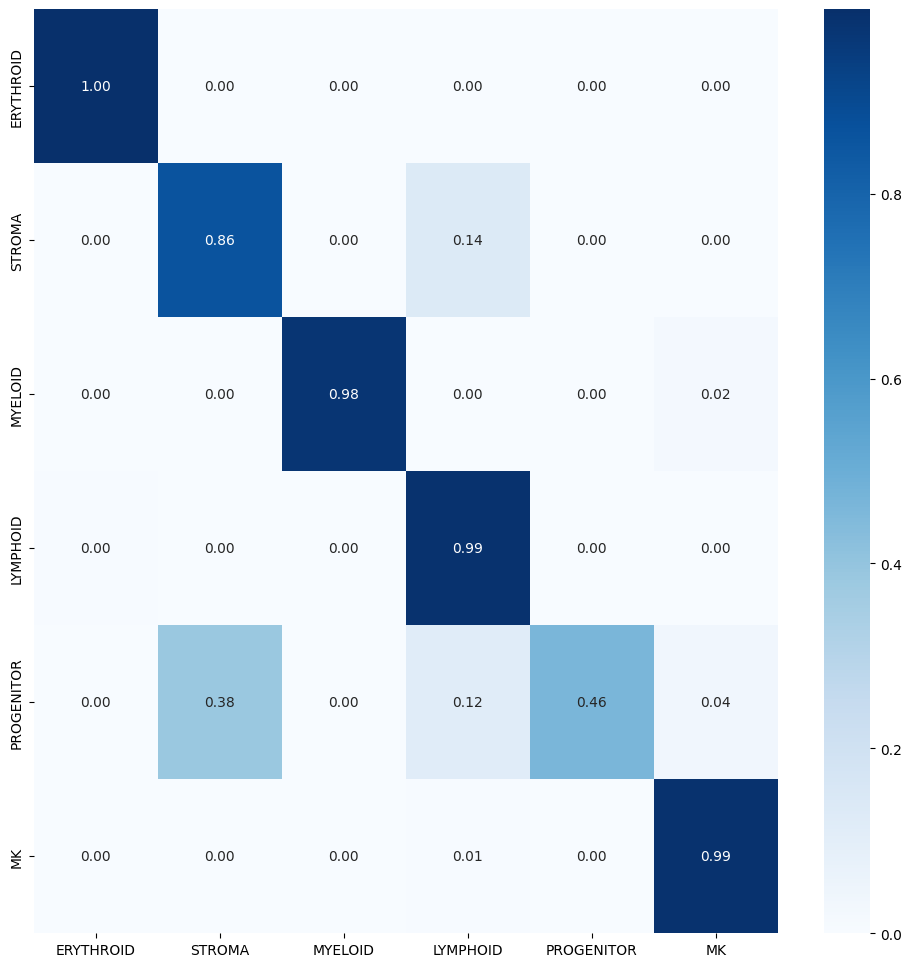

In [266]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print(np.unique(y_true_unseen))
set_predicted_cell_types = list(adata_unseen.obs["LVL1"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)
# ground truth on y axis, predicted on x axis
cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")

High recall, lower precision on Lymphoid cells

In [ ]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
labels = adata.obs["LVL1"].unique()
print(labels)
for i in range(6):
    #print(f"{labels[i]} has {len(adata[adata.obs["LVL1"]==labels[i]])} datapoints")
    print(labels[i],len(adata[adata.obs["LVL1"]==labels[i]]))

lymphoid_data = adata[adata.obs["LVL1"]==labels[5]]
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in lymphoid_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1

print(np.where(gene_list==29.0)[0])
knockout = np.where(gene_list==29.0)[0]



['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
STROMA 7824
ERYTHROID 3468
MYELOID 4888
MK 118
PROGENITOR 147
LYMPHOID 29
[ 5881  5883  9558  9788  9802  9902 10281 10975 11895 11968 12217 12525
 12538 13775 14048 14731 14739 14740 14742 14743 14824 14883 14994 15725
 16226 16227 16300 16379 16405 16720 16962 17219 17263 17264 17510 17653
 17682 17695 17858 17876 19349 22522 22524 22525 22526 22527 22531 22532
 22533 22723 22728 22829 23015 23037 23415 23682 23907 23995 24184 24328
 24484 24494 25142 25568 25613 25688 25941 25944 31320 31321 31323 31324
 31325 31326 31327 31328 31329 31331 31332 31333 31334 31335 31338 31340
 31341 31344 31346 31347 31348 31349 31350 31351 31352 31355 31356 31357
 31358 31361 31362 31363 31364 31367 31368 31369 31370 31371 31372 31374
 31375 31376 31377 31378 31398 31399 31400 31401 31402 31403 31404 31405
 31406 31407 31409 31411 31412 31413 31414 31415 31416 31417 31419 31421
 31422 31423 31426 31427 31441 31442 31443 31444 31968 32020 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): dataset that is being considered
      model ()
  """
  # knockout genes using batching to reduce explosion in RAM usage
  batch_size = 100
  original_data = data.copy()
  #print(len(genes))
  
  #gene_indices = [data.var.index.get_loc(gene) for gene in genes if gene in data.var.index]
  # update data in a vectorised way all at once to reduce memory spike
  data.X[:,genes] = 0 
  
  new_data = model.process_data(adata = data, gene_names="gene_name")
  print([i for i in knockout if data.var["gene_name"][i] not in new_data.vocab])
  
  
  x_model_dropped = model.get_embeddings(new_data)
  # generate embeddings on original data
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  x_model = model.get_embeddings(new_data1)
  return x_model, x_model_dropped
#genes_to_knockout = ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M']
#genes_to_knockout = list(adata.var_names[0:40])

x_model, x_model_dropped = knockout_genes(adata,scgpt,knockout)



INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17219, 17263, 17264]


Embedding cells: 100%|██████████| 330/330 [03:28<00:00,  1.59it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [09:02<00:00,  1.64s/it]


Evaluation set accuracy: 99.2%
Evaluation set precision: 86.5%
Evaluation set f1: 86.6%
Evaluation set recall: 88.0%
Lymphoid precision: 63.3%
Lymphoid f1: 73.1%
Lymphoid recall: 86.4% for no knockout


Evaluation set accuracy: 99.2%
Evaluation set precision: 84.4%
Evaluation set f1: 85.6%
Evaluation set recall: 88.0%
Lymphoid precision: 59.4%
Lymphoid f1: 70.4%
Lymphoid recall: 86.4% for knockout